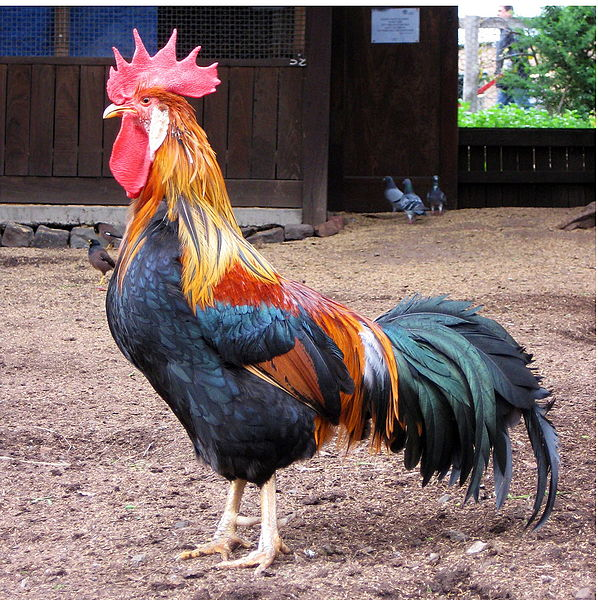

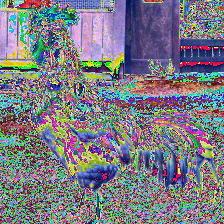

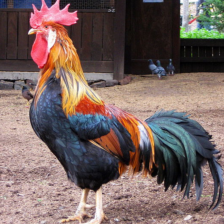

In [47]:
import numpy as np
from torchvision import transforms
from PIL import Image
import torch

crop = [224, 224]
resize = [256, 256]
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

rooster_image =  Image.open("data/rooster.jpg")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# show unmodified image
display(rooster_image)

# transform the image as in resnet50
transoformation = transforms.Compose([
    transforms.Resize(resize),
    transforms.CenterCrop(crop),
    transforms.ToTensor()
])
norm = transforms.Normalize(mean, std)
tensor_to_image = transforms.ToPILImage()
rooster_bn = transoformation(rooster_image)

transform = transforms.Compose([transoformation, norm])
rooster = norm(rooster_bn)
# show modified image
display(tensor_to_image(rooster.squeeze()))
display(tensor_to_image(rooster_bn.squeeze()))

rooster = rooster.unsqueeze(0)

In [48]:
import torchvision.models as models
import torch.nn.functional as F

# load pretrained resnet50 and get prediction
resnet = models.resnet50(pretrained = True)
resnet = resnet.eval()

prediction = F.softmax(resnet(rooster), dim=1)

def load_labels() -> list[str]:
    with open("data/labels.txt") as f:
        labels = [" ".join(line.strip().split(" ")[1::]) for line in f.readlines()]
    return labels

labels = load_labels()

score, indx = torch.topk(prediction, 5)
score = score.squeeze()
indx = indx.squeeze()
for s, i in zip(score, indx[:5]):
    print(f"prediction is: {labels[i]} with score: {s}")
# get best predictions

prediction is: cock with score: 0.9977686405181885
prediction is: hen with score: 0.0021682451479136944
prediction is: partridge with score: 6.5536642068764195e-06
prediction is: macaw with score: 4.341898602433503e-06
prediction is: peacock with score: 3.875074980896898e-06


In [85]:
def saliency(img, model, transformation):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #transoform input with the given transformation
    input = transformation(img)
    input = input.unsqueeze(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    predictions = model(input)
    score, _ = torch.topk(predictions, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()

    #get max along channel axis
    return torch.max(torch.abs(input.grad[0]), dim=0)


None
tensor([[[ 3.2329e-02, -2.0738e-02, -2.8613e-02,  ...,  2.0135e-03,
          -2.1893e-03,  2.0992e-04],
         [-2.7562e-02, -3.9833e-02, -2.1195e-02,  ..., -1.6165e-03,
          -2.1827e-03, -8.2070e-03],
         [-5.2877e-02, -8.2694e-02, -7.1214e-02,  ..., -3.1917e-03,
          -3.1849e-03, -4.2855e-03],
         ...,
         [ 6.3864e-03,  6.3220e-03, -7.3298e-03,  ...,  4.1505e-03,
           1.4131e-02,  2.1867e-02],
         [-8.7345e-04,  1.1203e-02, -1.0044e-03,  ...,  2.0125e-03,
          -3.7995e-03,  2.6237e-03],
         [-9.1534e-03,  8.7462e-03,  5.1219e-03,  ..., -9.0727e-03,
          -3.7841e-03,  2.1062e-04]],

        [[ 5.7278e-02, -1.4176e-02, -2.9336e-02,  ...,  5.4891e-04,
          -1.8031e-03,  8.5066e-04],
         [-2.9352e-02, -4.5815e-02, -1.6162e-02,  ..., -4.8644e-03,
          -4.5507e-03, -1.1809e-02],
         [-6.8223e-02, -9.2309e-02, -4.5671e-02,  ..., -4.9542e-03,
          -6.2938e-03, -8.0386e-03],
         ...,
         [-3.2840e-0

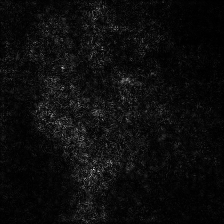

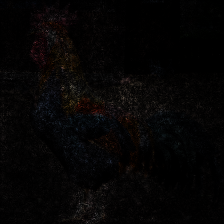

In [86]:
slc, _ = saliency(rooster_image, resnet, transoformation)
gxi = slc * transoformation(rooster_image)
display(tensor_to_image(slc))
display(tensor_to_image(gxi))